# Installs & Imports

In [1]:
!pip install -q pygam fred

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
from pygam import LinearGAM, s

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Load the Data

In [3]:
# Arguments
TARGET_COLUMN = "IPG2211A2N"  # Industrial Production: Electric and Gas Utilities
DATE_COLUMN = "DATE"          # Name of the date column

In [4]:
def load_electric_production_data(start_date="1985-01-01", end_date="2023-01-01"):
    """
    Fetches the Electric Production dataset from FRED (Federal Reserve Economic Data).

    Parameters:
    - start_date: Start date for the dataset.
    - end_date: End date for the dataset.

    Returns:
    - DataFrame containing the 'IPG2211A2N' time series.
    """
    df = pdr.get_data_fred(TARGET_COLUMN, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df.columns = [DATE_COLUMN, TARGET_COLUMN]
    df.set_index(DATE_COLUMN, inplace=True)
    print(f"Dataset loaded with {len(df)} rows.")
    return df

In [5]:
# Load the dataset
data = load_electric_production_data(start_date="1985-01-01", end_date="2023-01-01")
display(data.head())
print("\n")
display(data.tail())

Dataset loaded with 457 rows.


,IPG2211A2N
DATE,
1985-01-01,71.5943
1985-02-01,69.7893
1985-03-01,61.6809
1985-04-01,56.7497
1985-05-01,54.6182


,IPG2211A2N
DATE,
2022-09-01,100.9932
2022-10-01,91.0842
2022-11-01,99.8793
2022-12-01,118.3698
2023-01-01,115.4409


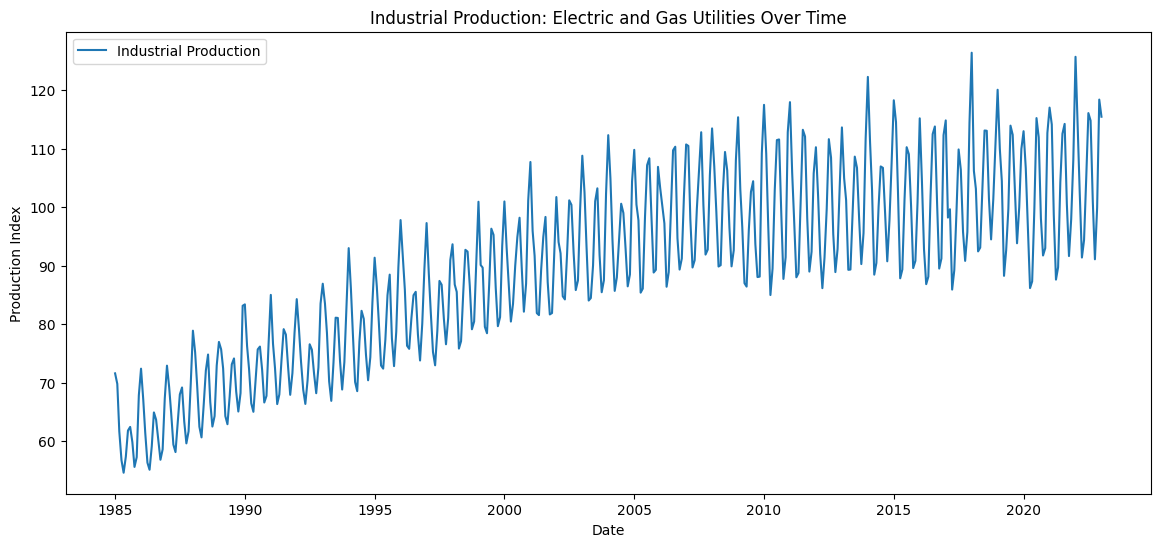

In [6]:
# Visualize the time series
plt.figure(figsize=(14, 6))
plt.plot(data.index, data[TARGET_COLUMN], label='Industrial Production')
plt.title('Industrial Production: Electric and Gas Utilities Over Time')
plt.xlabel('Date')
plt.ylabel('Production Index')
plt.legend()
plt.show()

# Split the Data

In [7]:
# Define the split ratio
train_ratio = 0.8
train_size = int(len(data) * train_ratio)

# Split the data
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 365
Testing set size: 92


# Define the Models

In [8]:
class NLARMA:
    def __init__(self, p, q, periods, weights):
        """
        Initializes the NL-ARMA model with specified parameters.

        Parameters:
        - p: int, AR order.
        - q: int, MA order.
        - periods: List[float], List of periods for cyclical components.
        - weights: List[float], List of weights for cyclical components.
        """
        self.p = p
        self.q = q
        self.periods = periods
        self.weights = weights
        self.params_ = None  # To store optimized parameters
        self.residuals = None  # To store residuals after fitting
        self.n_cycles = len(periods)

        # Validate input lengths
        if len(weights) != self.n_cycles:
            raise ValueError("Length of weights must match number of periods.")

    @staticmethod
    def nonlinear_function(x, a, b):
        """
        Bounded nonlinear transformation for AR and MA terms.

        Parameters:
        - x: float or np.ndarray, Input value(s) (previous data point or residual).
        - a: float, Parameter controlling the curvature.
        - b: float, Scaling parameter.

        Returns:
        - Transformed value(s) ensuring boundedness.
        """
        # Ensure numerical stability by avoiding negative values inside sqrt
        return b * np.sqrt(np.maximum(0, 1 - a * np.square(x)))

    def loss_function(self, params, data):
        """
        Loss function to be minimized during optimization.

        Parameters:
        - params: np.ndarray, Array of parameters [a, b, a_ma, b_ma, ar1, ..., arp, ma1, ..., maq, a_cycle1, b_cycle1, ...].
        - data: np.ndarray, Time series data.

        Returns:
        - float, Mean Squared Error of the residuals.
        """
        p, q, periods, weights = self.p, self.q, self.periods, self.weights
        n = len(data)
        residuals = np.zeros(n)

        # Extract parameters
        a = params[0]
        b = params[1]
        a_ma = params[2]
        b_ma = params[3]
        ar_coeffs = params[4:4 + p]
        ma_coeffs = params[4 + p:4 + p + q]
        a_cycles = params[4 + p + q:4 + p + q + self.n_cycles]
        b_cycles = params[4 + p + q + self.n_cycles:4 + p + q + 2 * self.n_cycles]

        # Precompute cyclical components
        cycle_terms = np.zeros(n)
        for j in range(self.n_cycles):
            cycle_input = weights[j] * np.sin(2 * np.pi * np.arange(n) / periods[j])
            transformed_cycle = self.nonlinear_function(cycle_input, a_cycles[j], b_cycles[j])
            cycle_terms += transformed_cycle

        # Iterate over time steps to compute residuals
        for t in range(max(p, q), n):
            # AR component
            if p > 0:
                ar_inputs = data[t - p:t][::-1]  # Previous p data points
                transformed_ar = self.nonlinear_function(ar_inputs, a, b)
                ar_part = np.dot(ar_coeffs, transformed_ar)
            else:
                ar_part = 0.0

            # MA component
            if q > 0:
                ma_inputs = residuals[t - q:t][::-1]  # Previous q residuals
                transformed_ma = self.nonlinear_function(ma_inputs, a_ma, b_ma)
                ma_part = np.dot(ma_coeffs, transformed_ma)
            else:
                ma_part = 0.0

            # Prediction and residual
            predicted = ar_part + ma_part + cycle_terms[t]
            residuals[t] = data[t] - predicted

        # Store residuals for forecasting
        self.residuals = residuals.copy()

        # Calculate Mean Squared Error, ignoring initial max(p, q) residuals
        mse = np.mean(residuals[max(p, q):] ** 2)
        return mse

    def fit(self, data, initial_params=None, verbose=False):
        """
        Fits the NL-ARMA model by optimizing the parameters.

        Parameters:
        - data: array-like, Time series data.
        - initial_params: array-like or None, Initial guess for parameters.
        - verbose: bool, If True, prints optimization details.

        Returns:
        - self: Fitted model instance.
        """
        data = np.asarray(data)
        num_cycles = self.n_cycles
        p, q = self.p, self.q

        if initial_params is None:
            # Initialize parameters: [a, b, a_ma, b_ma, ar_coeffs..., ma_coeffs..., a_cycle1, b_cycle1, ...]
            initial_a = 0.1
            initial_b = 1.0
            initial_a_ma = 0.1 if q > 0 else []
            initial_b_ma = 1.0 if q > 0 else []
            initial_ar = np.full(p, 0.1) if p > 0 else []
            initial_ma = np.full(q, 0.1) if q > 0 else []
            initial_cycles = np.full(num_cycles, 0.1)
            initial_cycles_b = np.full(num_cycles, 1.0)
            initial_params = [initial_a, initial_b, initial_a_ma, initial_b_ma] + \
                             initial_ar.tolist() + initial_ma.tolist() + \
                             initial_cycles.tolist() + initial_cycles_b.tolist()

        # Define bounds
        bounds = [
            (1e-5, 1.0),  # a
            (1e-5, None),  # b
            (1e-5, 1.0) if q > 0 else (),
            (1e-5, None) if q > 0 else ()
        ]
        # AR coefficients: no bounds (assuming linear coefficients can be any real number)
        bounds += [(None, None)] * p

        # MA coefficients: no bounds
        bounds += [(None, None)] * q

        # Cyclical a and b parameters
        for _ in range(num_cycles):
            bounds += [(1e-5, 1.0), (1e-5, None)]

        # Remove empty tuples for p=0 or q=0
        bounds = [b for b in bounds if b != ()]

        # Perform optimization
        result = minimize(
            self.loss_function,
            initial_params,
            args=(data,),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000, 'disp': verbose}
        )

        if result.success:
            self.params_ = result.x
            if verbose:
                print("NL-ARMA model fitted successfully.")
                print("Optimized parameters:", self.params_)
        else:
            raise ValueError(f"Optimization failed: {result.message}")

        return self

    def forecast(self, data, steps, stochastic=True, random_state=None):
        """
        Generates forecasts using the fitted NL-ARMA model.

        Parameters:
        - data: array-like, Time series data.
        - steps: int, Number of forecast steps.
        - stochastic: bool, If True, residuals are sampled from fitted residuals.
                            If False, residuals are set to zero (deterministic forecast).
        - random_state: int or None, Seed for random number generator for reproducibility.

        Returns:
        - np.ndarray, Array of forecasted values.
        """
        if self.params_ is None:
            raise ValueError("Model is not fitted yet. Call fit() before forecasting.")

        data = np.asarray(data).tolist()
        p, q, periods, weights = self.p, self.q, self.periods, self.weights
        forecast = []

        # Extract parameters
        idx = 0
        a = self.params_[idx]; idx +=1
        b = self.params_[idx]; idx +=1
        a_ma = self.params_[idx] if q > 0 else None; idx +=1 if q >0 else 0
        b_ma = self.params_[idx] if q > 0 else None; idx +=1 if q >0 else 0
        ar_coeffs = self.params_[idx:idx + p] if p > 0 else np.array([]); idx += p
        ma_coeffs = self.params_[idx:idx + q] if q > 0 else np.array([]); idx += q
        a_cycles = self.params_[idx:idx + self.n_cycles]; idx += self.n_cycles
        b_cycles = self.params_[idx:idx + self.n_cycles]; idx += self.n_cycles

        # Initialize residuals with the last q residuals from training
        if self.residuals is not None and q > 0:
            residuals = list(self.residuals[-q:])
        else:
            residuals = [0.0] * q  # Initialize with zeros if no residuals are available

        # Prepare residual sampling if stochastic forecasting is enabled
        if stochastic:
            if self.residuals is None or len(self.residuals) < max(p, q):
                raise ValueError("Insufficient residuals available for stochastic forecasting.")
            rng = np.random.default_rng(random_state)
            fitted_residuals = self.residuals[max(p, q):]  # Exclude initial residuals
            if len(fitted_residuals) == 0:
                raise ValueError("No residuals available for sampling.")

        for step in range(steps):
            t = len(data)

            # AR component
            if p > 0:
                ar_inputs = np.array(data[-p:])
                transformed_ar = self.nonlinear_function(ar_inputs, a, b)
                ar_part = np.dot(ar_coeffs, transformed_ar)
            else:
                ar_part = 0.0

            # MA component
            if q > 0:
                ma_inputs = np.array(residuals[-q:])
                transformed_ma = self.nonlinear_function(ma_inputs, a_ma, b_ma)
                ma_part = np.dot(ma_coeffs, transformed_ma)
            else:
                ma_part = 0.0

            # Cyclical component
            cycle_terms = 0.0
            for j in range(self.n_cycles):
                cycle_input = weights[j] * np.sin(2 * np.pi * t / periods[j])
                transformed_cycle = self.nonlinear_function(cycle_input, a_cycles[j], b_cycles[j])
                cycle_terms += transformed_cycle

            # Prediction
            predicted = ar_part + ma_part + cycle_terms
            forecast.append(predicted)
            data.append(predicted)

            # Update residuals
            if q > 0:
                if stochastic:
                    # Sample a residual from the fitted residuals
                    sampled_residual = rng.choice(fitted_residuals)
                    residuals.append(sampled_residual)
                else:
                    # Deterministic forecast: assume residual is zero
                    residuals.append(0.0)

        return np.array(forecast)

In [9]:
class GAMARMA:
    def __init__(self, arma_order=(2, 2), seasonal_periods=[12, 24]):
        """
        Initializes the GAM-ARMA model with specified ARMA order and seasonal periods.

        Parameters:
        - arma_order: Tuple representing (p, q) orders for ARMA.
        - seasonal_periods: List of integers representing seasonal periods for feature engineering.
        """
        self.gam_model = None
        self.arma_model = None
        self.arma_order = arma_order
        self.seasonal_periods = seasonal_periods
        self.fitted = False
        self.differenced = False
        self.last_residual = None

    def prepare_features(self, data):
        """
        Prepares time-based features for GAM, including trend and seasonal components.

        Parameters:
        - data: Time series data as a NumPy array or Pandas Series.

        Returns:
        - DataFrame with engineered features.
        """
        if not isinstance(data, (np.ndarray, pd.Series, pd.DataFrame)):
            raise TypeError("Data should be a NumPy array, Pandas Series, or DataFrame.")

        n = len(data)
        t = np.arange(n)
        features = {'t': t}

        # Add seasonal features based on specified periods
        for period in self.seasonal_periods:
            features[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
            features[f'cos_{period}'] = np.cos(2 * np.pi * t / period)

        df_features = pd.DataFrame(features)
        return df_features

    def check_stationarity(self, residuals, significance_level=0.05):
        """
        Performs the Augmented Dickey-Fuller test to check for stationarity in residuals.

        Parameters:
        - residuals: Residuals from the GAM fit.
        - significance_level: Threshold for p-value to reject the null hypothesis.

        Returns:
        - Boolean indicating stationarity.
        """
        result = adfuller(residuals)
        p_value = result[1]
        return p_value < significance_level

    def fit_gam(self, X, y):
        """
        Fits a GAM to the data.

        Parameters:
        - X: Feature matrix as a Pandas DataFrame.
        - y: Target variable as a NumPy array or Pandas Series.

        Returns:
        - Fitted GAM model.
        """
        # Define the GAM with smooth terms for each feature
        gam = LinearGAM().fit(X, y)
        self.gam_model = gam
        print("GAM part fitted successfully.")
        return gam

    def fit_arma(self, residuals):
        """
        Fits an ARMA model to the residuals if they are stationary.
        Attempts differencing if residuals are non-stationary.

        Parameters:
        - residuals: Residuals from the GAM fit.

        Returns:
        - Fitted ARMA model.
        """
        # Check for stationarity
        if not self.check_stationarity(residuals):
            warnings.warn("Residuals are non-stationary. Applying first-order differencing.")
            residuals = np.diff(residuals)
            self.differenced = True
            self.last_residual = residuals[-1]  # Store the last residual for integration
        else:
            self.differenced = False
            self.last_residual = residuals[-1]

        try:
            # ARIMA expects a three-element tuple (p, d, q)
            p, q = self.arma_order
            d = 0  # No differencing for ARMA; differencing is handled separately
            arma = ARIMA(residuals, order=(p, d, q)).fit()
            self.arma_model = arma
            print(f"ARMA part fitted successfully with order {(p, d, q)}.")
            return arma
        except Exception as e:
            raise ValueError(f"Failed to fit ARMA model: {e}")

    def fit(self, data):
        """
        Fits the GAM-ARMA model to the data.

        Parameters:
        - data: Time series data as a NumPy array or Pandas Series.

        Returns:
        - self: Fitted GAMARMA instance.
        """
        # Convert data to Pandas Series for consistency
        if isinstance(data, np.ndarray):
            data = pd.Series(data)
        elif isinstance(data, pd.DataFrame):
            if data.shape[1] != 1:
                raise ValueError("DataFrame should have only one column for the target variable.")
            data = data.iloc[:, 0]
        elif not isinstance(data, pd.Series):
            raise TypeError("Data should be a NumPy array, Pandas Series, or single-column DataFrame.")

        # Prepare features
        X = self.prepare_features(data)
        y = data.values

        # Fit GAM
        self.fit_gam(X, y)

        # Get residuals
        residuals = y - self.gam_model.predict(X)

        # Fit ARMA on residuals
        self.fit_arma(residuals)

        self.fitted = True
        return self

    def predict_gam(self, X):
        """
        Predicts using the fitted GAM model.

        Parameters:
        - X: Feature matrix as a Pandas DataFrame.

        Returns:
        - Predicted mean values as a NumPy array.
        """
        if self.gam_model is None:
            raise ValueError("GAM model is not fitted yet.")
        return self.gam_model.predict(X)

    def forecast_arma(self, steps):
        """
        Forecasts residuals using the fitted ARMA model.

        Parameters:
        - steps: Number of steps to forecast.

        Returns:
        - Forecasted residuals as a NumPy array.
        """
        if self.arma_model is None:
            raise ValueError("ARMA model is not fitted yet.")
        forecast = self.arma_model.forecast(steps=steps)
        return forecast

    def forecast(self, last_X, steps):
        """
        Generates forecasts by combining GAM and ARMA predictions.

        Parameters:
        - last_X: Feature matrix for the last known data point(s) as a Pandas DataFrame.
        - steps: Number of steps to forecast.

        Returns:
        - Forecasted values as a NumPy array.
        """
        if not self.fitted:
            raise ValueError("The model must be fitted before forecasting.")

        forecasts = []
        current_X = last_X.copy()
        residuals_forecast = self.arma_model.forecast(steps=steps)

        # Initialize the last residual value for integration
        if self.differenced:
            # Use the last residual from the original residuals before differencing
            last_residual = self.last_residual
        else:
            last_residual = 0  # If not differenced, assume last residual is zero

        for step in range(steps):
            # Predict GAM mean for the next step
            gam_pred = self.gam_model.predict(current_X)[0]

            # Get the corresponding ARMA residual forecast
            arma_pred = residuals_forecast[step]

            # If differenced, integrate the residual forecast
            if self.differenced:
                # Cumulative sum to invert differencing
                last_residual = last_residual + arma_pred
                residual_pred = last_residual
            else:
                residual_pred = arma_pred

            # Combine predictions
            forecast = gam_pred + residual_pred
            forecasts.append(forecast)

            # Update features for the next step
            next_t = current_X['t'].values[0] + 1
            new_features = {}
            new_features['t'] = next_t
            for period in self.seasonal_periods:
                new_features[f'sin_{period}'] = np.sin(2 * np.pi * next_t / period)
                new_features[f'cos_{period}'] = np.cos(2 * np.pi * next_t / period)
            current_X = pd.DataFrame(new_features, index=[0])

        return np.array(forecasts)

# Initialize the Models

In [10]:
# Define NL-ARMA parameters
nl_arma_p = 2  # AR order
nl_arma_q = 2  # MA order
nl_arma_periods = [12, 24]  # Periods for cyclical components (monthly, bi-monthly)
nl_arma_weights = [0.5, 0.3]  # Weights

# Initialize NL-ARMA model
nl_arma_model = NLARMA(p=nl_arma_p, q=nl_arma_q, periods=nl_arma_periods, weights=nl_arma_weights)

In [11]:
# Define GAM-ARMA parameters
gamarma_arma_order = (2, 2)  # (p, q) for ARMA part
gamarma_seasonal_periods = [12, 24]  # Seasonal periods

# Initialize GAM-ARMA model
gamarma_model = GAMARMA(arma_order=gamarma_arma_order, seasonal_periods=gamarma_seasonal_periods)

In [12]:
# Define ARMA parameters
arma_p = 2  # AR order
arma_q = 2  # MA order

# Initialize ARMA model (ARIMA with d=0)
arma_order = (arma_p, 0, arma_q)

# Fit & Predict

In [13]:
# Fit NL-ARMA model
print("Fitting NL-ARMA model...")
nl_arma_model.fit(train_data[TARGET_COLUMN].values, verbose=True)

# Make predictions
print("Forecasting with NL-ARMA model...")
nl_arma_forecasts = []
history = train_data[TARGET_COLUMN].values.tolist()

for i in range(len(test_data)):
    # Forecast one step ahead
    forecast = nl_arma_model.forecast(history, steps=1, stochastic=True)
    nl_arma_forecasts.append(forecast[0])

    # Append the actual value to history for next prediction
    history.append(forecast[0])

Fitting NL-ARMA model...
NL-ARMA model fitted successfully.
Optimized parameters: [1.00000000e-01 1.00000000e+00 6.72785079e-03 3.81948944e+00
 1.00000000e-01 1.00000000e-01 2.03320959e+00 3.70736914e+00
 1.00000000e+00 1.92254824e+00 9.96084546e-01 8.36224406e+01]
Forecasting with NL-ARMA model...


In [14]:
# Fit GAM-ARMA model
print("Fitting GAM-ARMA model...")
gamarma_model.fit(train_data[TARGET_COLUMN].values)

# Make predictions
print("Forecasting with GAM-ARMA model...")
gamarma_forecasts = []
history = train_data.copy()

for i in range(len(test_data)):
    # Prepare features for the next step
    last_X = gamarma_model.prepare_features(history[TARGET_COLUMN].values)[-1:]

    # Forecast one step ahead
    forecast = gamarma_model.forecast(last_X, steps=1)
    gamarma_forecasts.append(forecast[0])

    # Append the forecast to history for next prediction
    # Since we are using date indices, we need to determine the next date
    last_date = history.index[-1]

    # Monthly data
    try:
        next_date = last_date + pd.DateOffset(months=1)
    except:
        # Fallback if DateOffset fails
        next_date = last_date + pd.Timedelta(days=30)
    new_entry = pd.DataFrame({TARGET_COLUMN: [forecast[0]]}, index=[next_date])
    history = pd.concat([history, new_entry])

Fitting GAM-ARMA model...
GAM part fitted successfully.
ARMA part fitted successfully with order (2, 0, 2).
Forecasting with GAM-ARMA model...


In [15]:
# Fit ARMA model
print("Fitting ARMA model...")
arma_model = ARIMA(train_data[TARGET_COLUMN], order=arma_order).fit()

# Make predictions
print("Forecasting with ARMA model...")
arma_forecasts = arma_model.forecast(steps=len(test_data))
arma_forecasts = arma_forecasts.values  # Convert to NumPy array

Fitting ARMA model...
Forecasting with ARMA model...


# Model Metrics

In [16]:
def evaluate_model(true, predicted):
    """
    Evaluates the model's performance using common error metrics.

    Parameters:
    - true: Actual values.
    - predicted: Forecasted values.

    Returns:
    - Dictionary containing error metrics.
    """
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(true - predicted))
    mape = mean_absolute_percentage_error(true, predicted) * 100
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [17]:
# Actual values
y_true = test_data[TARGET_COLUMN].values

# Evaluate models
nl_arma_metrics = evaluate_model(y_true, np.array(nl_arma_forecasts))
gamarma_metrics = evaluate_model(y_true, np.array(gamarma_forecasts))
arma_metrics = evaluate_model(y_true, arma_forecasts)

# Display metrics
print("Model Performance Metrics:")
print(f"NL-ARMA: {nl_arma_metrics}")
print(f"GAM-ARMA: {gamarma_metrics}")
print(f"ARMA: {arma_metrics}")

Model Performance Metrics:
NL-ARMA: {'MSE': 104.5332105383845, 'RMSE': 10.224148401621745, 'MAE': 8.716053727359567, 'MAPE': 8.399701590896672}
GAM-ARMA: {'MSE': 64.73287732473571, 'RMSE': 8.045674448095431, 'MAE': 6.840893367221054, 'MAPE': 6.565670453792848}
ARMA: {'MSE': 112.30103961848172, 'RMSE': 10.59721848498377, 'MAE': 8.77801265745565, 'MAPE': 8.358249666535999}


In [18]:
# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Model': ['NL-ARMA', 'GAM-ARMA', 'ARMA'],
    'MSE': [nl_arma_metrics['MSE'], gamarma_metrics['MSE'], arma_metrics['MSE']],
    'RMSE': [nl_arma_metrics['RMSE'], gamarma_metrics['RMSE'], arma_metrics['RMSE']],
    'MAE': [nl_arma_metrics['MAE'], gamarma_metrics['MAE'], arma_metrics['MAE']],
    'MAPE': [nl_arma_metrics['MAPE'], gamarma_metrics['MAPE'], arma_metrics['MAPE']],
})

# Display the comparison table
metrics_df

,Model,MSE,RMSE,MAE,MAPE
0,NL-ARMA,104.533211,10.224148,8.716054,8.399702
1,GAM-ARMA,64.732877,8.045674,6.840893,6.565670
2,ARMA,112.301040,10.597218,8.778013,8.358250


# Model Plots

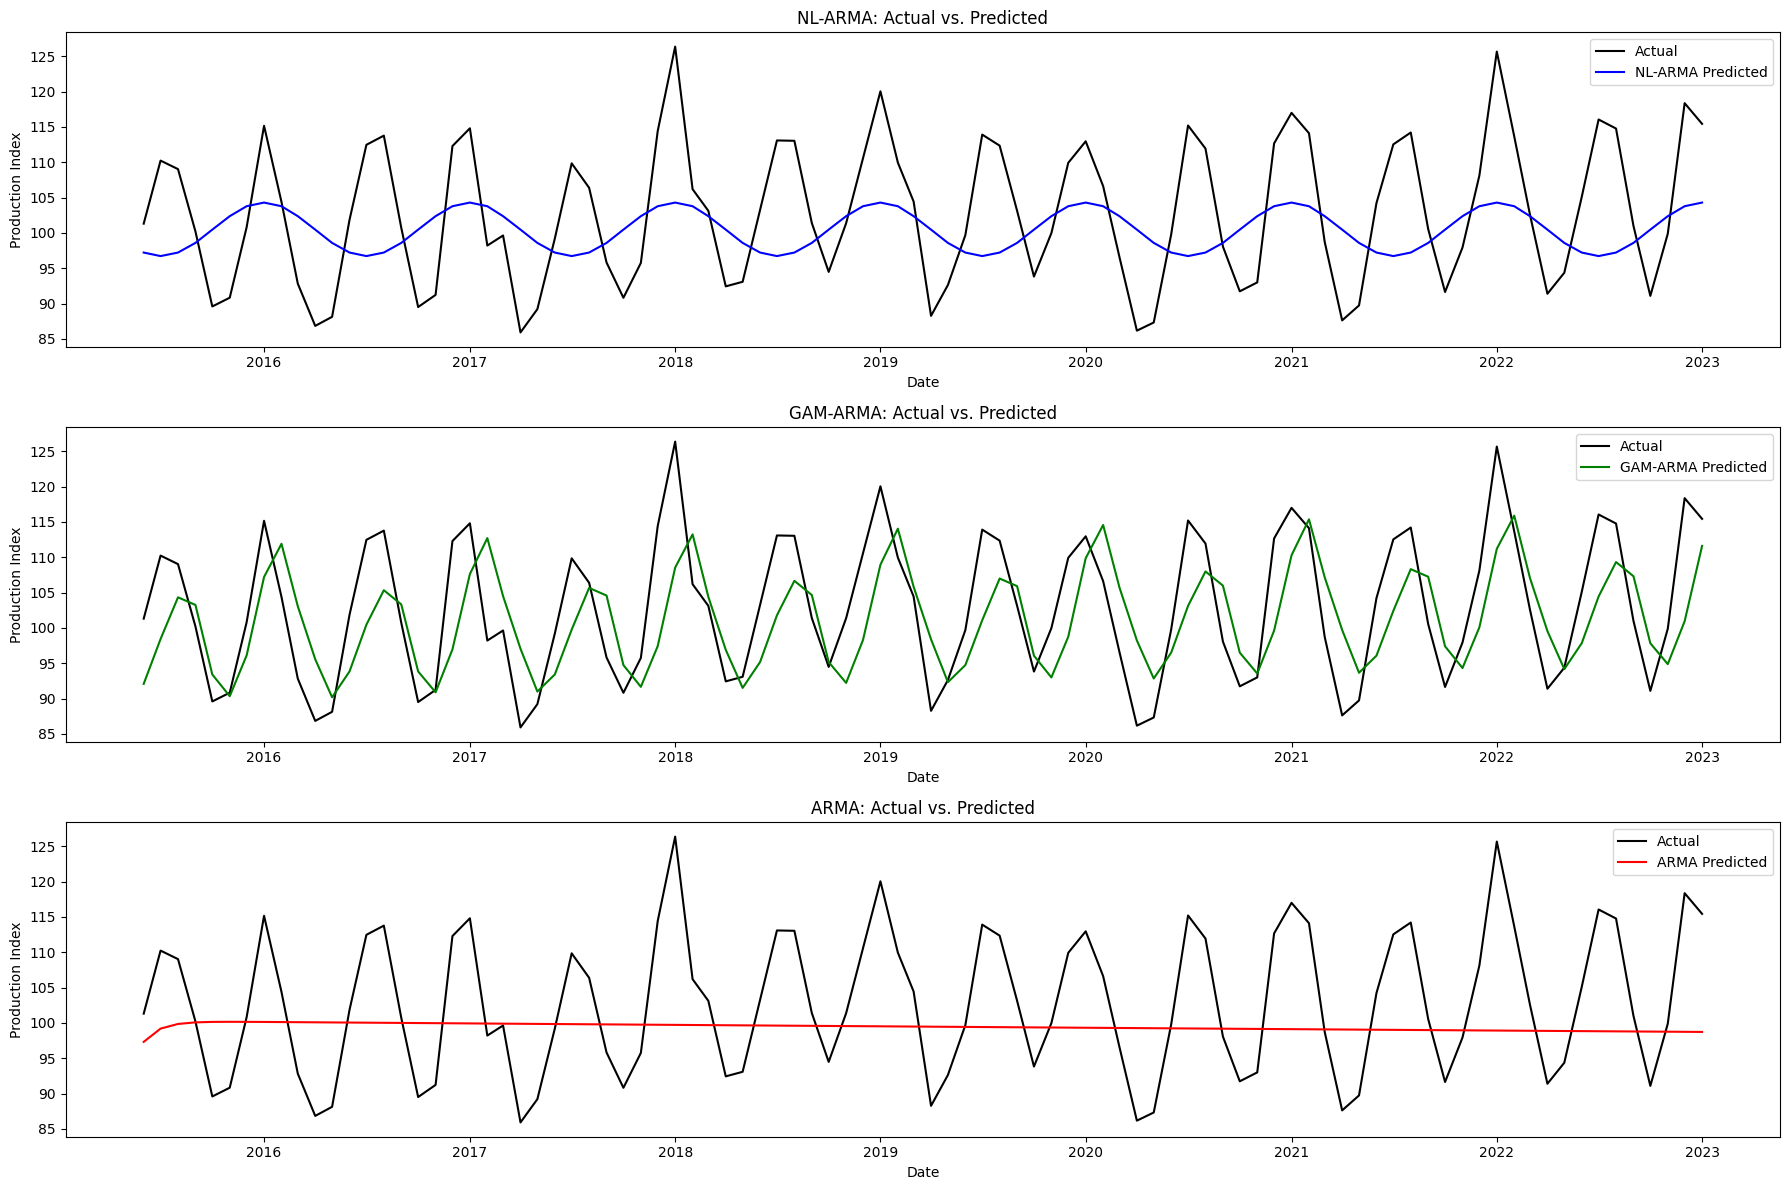

In [19]:
# Create a date range for the test set
test_dates = test_data.index

# Plot settings
plt.figure(figsize=(18, 12))

# NL-ARMA Predictions
plt.subplot(3, 1, 1)
plt.plot(test_dates, y_true, label='Actual', color='black')
plt.plot(test_dates, nl_arma_forecasts, label='NL-ARMA Predicted', color='blue')
plt.title('NL-ARMA: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Production Index')
plt.legend()

# GAM-ARMA Predictions
plt.subplot(3, 1, 2)
plt.plot(test_dates, y_true, label='Actual', color='black')
plt.plot(test_dates, gamarma_forecasts, label='GAM-ARMA Predicted', color='green')
plt.title('GAM-ARMA: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Production Index')
plt.legend()

# ARMA Predictions
plt.subplot(3, 1, 3)
plt.plot(test_dates, y_true, label='Actual', color='black')
plt.plot(test_dates, arma_forecasts, label='ARMA Predicted', color='red')
plt.title('ARMA: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Production Index')
plt.legend()

plt.tight_layout()
plt.show()